In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/gps-data/geo_locations_astana_hackathon.csv")

print(df.head(10))

df


         randomized_id        lat        lng         alt        spd  \
0  7637058049336049989  51.095460  71.427530  350.531020   0.206810   
1  1259981924615926140  51.098200  71.412950  348.801610   0.000000   
2  1259981924615926140  51.098460  71.412120  349.273880   4.345010   
3  7180852955221959108  51.089779  71.428469  314.000000  14.326102   
4 -6683155579225977143  51.088782  71.417462  325.300018   0.000602   
5 -9163058962347897266  51.094540  71.407610  349.611830   4.017780   
6  5965568696283616614  51.098690  71.405960  351.530580  11.163660   
7  5965568696283616614  51.100380  71.406630  350.854700  12.834050   
8  8912987557492744692  51.094420  71.404380  321.400024  15.889509   
9  8912987557492744692  51.093588  71.404084  321.400024  15.399438   

          azm  
0   13.601680  
1  265.677000  
2  307.245300  
3  192.123672  
4    0.000000  
5  170.381230  
6  247.881290  
7  216.541870  
8  191.993423  
9  190.944016  


,randomized_id,lat,lng,alt,spd,azm
0,7637058049336049989,51.095460,71.427530,350.531020,0.206810,13.601680
1,1259981924615926140,51.098200,71.412950,348.801610,0.000000,265.677000
2,1259981924615926140,51.098460,71.412120,349.273880,4.345010,307.245300
3,7180852955221959108,51.089779,71.428469,314.000000,14.326102,192.123672
4,-6683155579225977143,51.088782,71.417462,325.300018,0.000602,0.000000
...,...,...,...,...,...,...
1262682,-4159094440281962734,51.095327,71.409942,328.400024,0.306837,286.840027
1262683,-4159094440281962734,51.095346,71.410199,328.400024,0.760408,263.180573
1262684,-4159094440281962734,51.095343,71.410272,328.400024,1.768341,89.564423
1262685,-4159094440281962734,51.095339,71.410246,328.400024,0.288987,211.242523


In [2]:
num_rows = len(df)
print("Number of rows in dataset:", num_rows)

Number of rows in dataset: 1262687


In [3]:
# Choose one person's ID (example: first ID in dataset)
person_id = df["randomized_id"].iloc[0]

# Filter dataseqt for that ID
person_data = df[df["randomized_id"] == person_id]

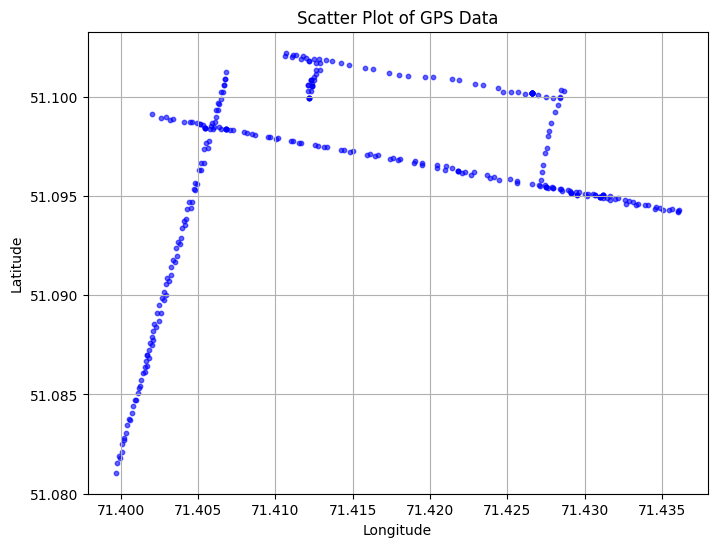

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(person_data["lng"], person_data["lat"], c="blue", s=10, alpha=0.6)

plt.title("Scatter Plot of GPS Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

0.14095
24.08304


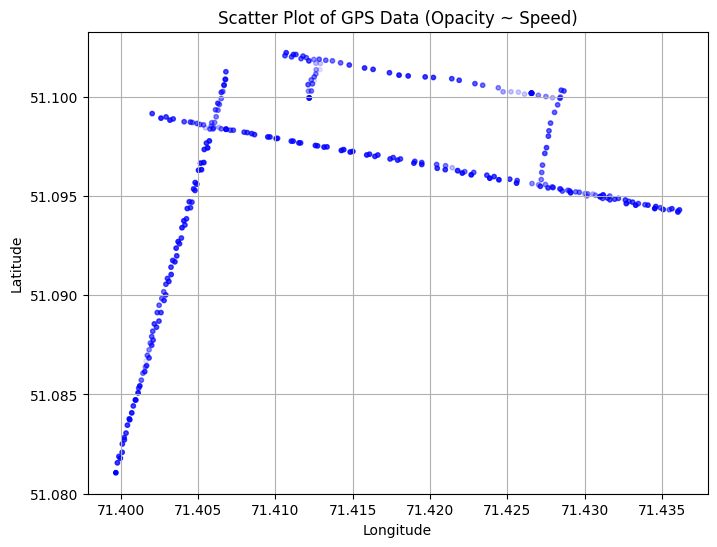

In [5]:
max_speed = person_data["spd"].max()
min_speed = person_data["spd"].min()
opacity = (person_data["spd"] - min_speed) / (max_speed - min_speed + 1e-9)
print(min_speed)
print(max_speed)

# Scatter plot with opacity based on speed
plt.figure(figsize=(8, 6))
plt.scatter(person_data["lng"], person_data["lat"], c="blue", s=10, alpha=opacity)

plt.title("Scatter Plot of GPS Data (Opacity ~ Speed)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

Detected segments: 1
First 5 start points: [(51.09546, 71.42753)]
First 5 end points:   [(51.10089, 71.40677)]


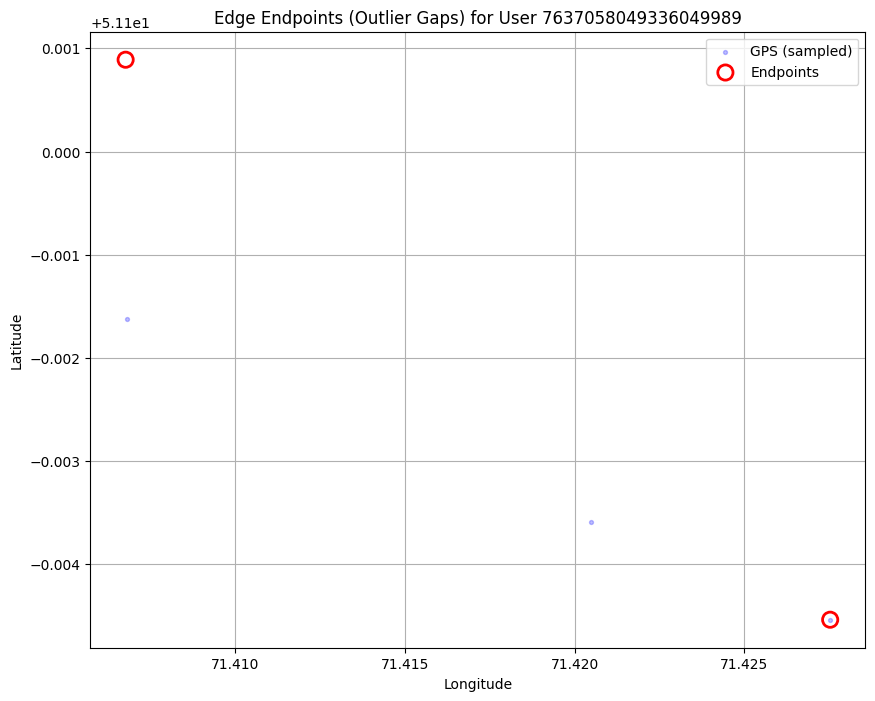

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Load and filter one user (row order assumed chronological for that user) ---
df = pd.read_csv("/kaggle/input/gps-data/geo_locations_astana_hackathon.csv")
person_id = df["randomized_id"].iloc[0]
person_data = df[df["randomized_id"] == person_id].reset_index(drop=True)

# --- Vectorized step distances (meters) between consecutive points ---
R = 6371000.0
phi = np.radians(person_data["lat"].to_numpy())
lam = np.radians(person_data["lng"].to_numpy())

dphi = phi[1:] - phi[:-1]
dlam = lam[1:] - lam[:-1]
a = np.sin(dphi/2.0)**2 + np.cos(phi[:-1]) * np.cos(phi[1:]) * np.sin(dlam/2.0)**2
step_m = 2.0 * R * np.arcsin(np.sqrt(a))  # length len=N-1

# --- Robust outlier threshold for gaps (treats ride boundaries as outliers) ---
q1 = np.quantile(step_m, 0.25) if len(step_m) else 0.0
q3 = np.quantile(step_m, 0.75) if len(step_m) else 0.0
iqr = q3 - q1
tukey = q3 + 3.0 * iqr                  # very conservative
q995 = np.quantile(step_m, 0.995) if len(step_m) else 0.0  # extreme tail
min_floor = 200.0                       # at least 200 m gap to split
dist_thresh = max(tukey, q995, min_floor)

# --- Break indices where the gap is an outlier ---
break_idx = np.where(step_m > dist_thresh)[0]  # boundary between i and i+1

# --- Segment boundaries (first/last index of each contiguous segment) ---
start_idx = np.r_[0, break_idx + 1]
end_idx   = np.r_[break_idx, len(person_data) - 1]

# Optional: drop tiny segments (noise); keep segments with >= min_points
min_points = 8
keep_mask = (end_idx - start_idx + 1) >= min_points
start_idx = start_idx[keep_mask]
end_idx   = end_idx[keep_mask]

# --- Extract endpoints (true edges only) ---
starts_lat = person_data["lat"].to_numpy()[start_idx]
starts_lng = person_data["lng"].to_numpy()[start_idx]
ends_lat   = person_data["lat"].to_numpy()[end_idx]
ends_lng   = person_data["lng"].to_numpy()[end_idx]

print(f"Detected segments: {len(start_idx)}")
print("First 5 start points:", list(zip(starts_lat[:5], starts_lng[:5])))
print("First 5 end points:  ", list(zip(ends_lat[:5],   ends_lng[:5])))

# --- Plot (sample route for speed; show only endpoints clearly) ---
mpl.rcParams['agg.path.chunksize'] = 10000
sample_rate = 150  # plot every Nth point to avoid overflow on million-row data
df_plot = person_data.iloc[::sample_rate]

plt.figure(figsize=(10, 8))
plt.scatter(df_plot["lng"], df_plot["lat"], c="blue", s=8, alpha=0.25, label="GPS (sampled)")

# red hollow circles for both starts and ends (edges)
plt.scatter(starts_lng, starts_lat, facecolors='none', edgecolors='red', s=120, linewidths=2, label="Endpoints")
plt.scatter(ends_lng,   ends_lat,   facecolors='none', edgecolors='red', s=120, linewidths=2)

plt.title(f"Edge Endpoints (Outlier Gaps) for User {person_id}")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend(); plt.grid(True)
plt.show()


In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/gps-data/geo_locations_astana_hackathon.csv")

all_rides = []

for person_id, person_data in df.groupby("randomized_id"):
    person_data = person_data.reset_index(drop=True)

    # --- compute step distances ---
    R = 6371000.0
    phi = np.radians(person_data["lat"].to_numpy())
    lam = np.radians(person_data["lng"].to_numpy())

    dphi = phi[1:] - phi[:-1]
    dlam = lam[1:] - lam[:-1]
    a = np.sin(dphi/2.0)**2 + np.cos(phi[:-1]) * np.cos(phi[1:]) * np.sin(dlam/2.0)**2
    step_m = 2.0 * R * np.arcsin(np.sqrt(a))

    # --- outlier threshold ---
    if len(step_m) > 0:
        q1, q3 = np.quantile(step_m, [0.25, 0.75])
        iqr = q3 - q1
        tukey = q3 + 3.0 * iqr
        q995 = np.quantile(step_m, 0.995)
        dist_thresh = max(tukey, q995, 200.0)
    else:
        dist_thresh = 200.0

    break_idx = np.where(step_m > dist_thresh)[0]

    # --- segment indices ---
    start_idx = np.r_[0, break_idx + 1]
    end_idx   = np.r_[break_idx, len(person_data) - 1]

    # drop very small segments
    min_points = 8
    keep_mask = (end_idx - start_idx + 1) >= min_points
    start_idx = start_idx[keep_mask]
    end_idx   = end_idx[keep_mask]

    # --- collect rides ---
    for i in range(len(start_idx)):
        all_rides.append({
            "randomized_id": person_id,
            "start_lat": person_data.loc[start_idx[i], "lat"],
            "start_lng": person_data.loc[start_idx[i], "lng"],
            "end_lat": person_data.loc[end_idx[i], "lat"],
            "end_lng": person_data.loc[end_idx[i], "lng"]
        })

ride_df = pd.DataFrame(all_rides)

print("Total rides detected:", len(ride_df))
print(ride_df.head(100))

Total rides detected: 7599
          randomized_id  start_lat  start_lng    end_lat    end_lng
0  -9221304899272910788  51.082958  71.422355  51.094996  71.416271
1  -9217374206810770265  51.088950  71.402459  51.082103  71.400054
2  -9214548556609186054  51.079424  71.421915  51.079512  71.421314
3  -9214033164510198912  51.098543  71.405789  51.097647  71.412581
4  -9212938812549517684  51.097703  71.411938  51.094448  71.424033
..                  ...        ...        ...        ...        ...
95 -9047494058275590180  51.100530  71.415710  51.101610  71.422900
96 -9045982928887159404  51.100950  71.409280  51.098920  71.402850
97 -9043791695275399136  51.101205  71.422267  51.100956  71.422189
98 -9043614323555733081  51.096588  71.419022  51.094242  71.436295
99 -9043614323555733081  51.099030  71.401817  51.098743  71.403816

[100 rows x 5 columns]


In [8]:
ride_df.to_csv("rides_dataset.csv", index=False)

In [9]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

# Center on Astana
center_lat = ride_df["start_lat"].mean()
center_lng = ride_df["start_lng"].mean()

# --- Pickup Heatmap ---
m_start = folium.Map(location=[center_lat, center_lng], zoom_start=12, tiles="cartodbpositron")
start_points = ride_df[["start_lat", "start_lng"]].dropna().values.tolist()
HeatMap(start_points, radius=8, blur=12, min_opacity=0.5).add_to(m_start)
m_start.save("/kaggle/working/pickup_heatmap.html")
display(m_start)

# --- Drop-off Heatmap ---
m_end = folium.Map(location=[center_lat, center_lng], zoom_start=12, tiles="cartodbpositron")
end_points = ride_df[["end_lat", "end_lng"]].dropna().values.tolist()
HeatMap(end_points, radius=8, blur=12, min_opacity=0.5, gradient={0.4:'blue',0.65:'cyan',1:'lime'}).add_to(m_end)
m_end.save("/kaggle/working/dropoff_heatmap.html")
display(m_end)